## Introduction:
While the XGBoost model tuned via RandomizedSearchCV delivered the highest performance on the test set (F1 = 0.90, AUC = 0.937), we present model drift analysis based on the Optuna-tuned variant for demonstration purposes, as it reflects a more systematic tuning process. This does not affect model deployment decisions, which remain based on the best-performing model.

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/survey.csv'
df = pd.read_csv(path, encoding='latin1')

df = df.drop(columns=['comments', 'Timestamp', 'state', 'no_employees', 'anonymity'])
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
df['self_employed'] = df['self_employed'].fillna('No')
df.drop_duplicates()
df['work_interfere'] = df['work_interfere'].fillna('Not applicable')

#Function to clean the gender variable into 'female', 'male', and 'other'
def clean_gender(gender):
    gender = str(gender).strip().lower()
    if gender in ['male', 'm', 'cis male', 'male (cis)', 'man', 'mail', 'cis man', 'malr', 'make', 'maile']:
        return 'Male'
    elif gender in ['female', 'f', 'cis female', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'femail', 'female ', 'trans female']:
        return 'Female'
    else:
        return 'Other'

# Apply the cleaning function
df['Gender'] = df['Gender'].apply(clean_gender)

for col in ['Gender','Country','self_employed','family_history','work_interfere','remote_work','tech_company','benefits','care_options',
            'wellness_program','seek_help','leave','mental_health_consequence','phys_health_consequence','coworkers','supervisor',
            'mental_health_interview','phys_health_interview','mental_vs_physical','obs_consequence']:
            vc = df[col].value_counts(normalize=True)
            rare = vc[vc < 0.01]

vc = df['Country'].value_counts(normalize=True)
rare = vc[vc < 0.01]
rare_labels = rare.index.tolist()
df['Country_grouped'] = df['Country'].replace(rare_labels, 'Other')

!pip install matplotlib-venn

# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

!pip install cartopy
import cartopy

!apt-get update -qq
!apt-get install -y libarchive-dev

!pip install libarchive-c

# Test
import libarchive
print("Import succeeded:", libarchive)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation
from sklearn.metrics import classification_report, roc_auc_score

# 1. Load and preprocess data
df['treatment'] = df['treatment'].map({'Yes': 1, 'No': 0})

# 2. Define features and target
cat_cols = [
    'Gender', 'Country_grouped', 'self_employed', 'family_history',
    'work_interfere', 'remote_work', 'tech_company', 'benefits',
    'care_options', 'wellness_program', 'seek_help', 'leave',
    'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview',
    'phys_health_interview', 'mental_vs_physical', 'obs_consequence'
]
num_cols = ['Age']
target = 'treatment'

X = df[cat_cols + num_cols]
y = df[target]

Mounted at /content/drive


<ipython-input-1-606f3d7825a2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['self_employed'] = df['self_employed'].fillna('No')
<ipython-input-1-606f3d7825a2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['work_interfere'] = df['work_interfere'].fillna('Not applicable')
<ipython-input-1-606f3d7825a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.4_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=065a7eb7a8d9740b6666c11fd9f0b507e52eeab4ce8bbc49a5349dc56183e8fd
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 94.5 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem t

Import succeeded: <module 'libarchive' from '/usr/local/lib/python3.11/dist-packages/libarchive/__init__.py'>


In [2]:
# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Semi-Supervised

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report

Define helper functions

In [4]:
def apply_pseudo_labeling(base_model, X_labeled, y_labeled, X_unlabeled, preprocessor=None, threshold=0.9):

    # Fit and transform preprocessing if provided
    if preprocessor is not None:
        preprocessor.fit(X_labeled)
        X_labeled_encoded = preprocessor.transform(X_labeled)
        X_unlabeled_encoded = preprocessor.transform(X_unlabeled)
    else:
        X_labeled_encoded = X_labeled
        X_unlabeled_encoded = X_unlabeled

    # Train the base model
    base_model.fit(X_labeled_encoded, y_labeled)

    # Predict pseudo-labels for unlabeled data
    proba_unlabeled = base_model.predict_proba(X_unlabeled_encoded)
    preds_unlabeled = np.argmax(proba_unlabeled, axis=1)
    max_proba = np.max(proba_unlabeled, axis=1)

    # Select high-confidence pseudo-labeled samples
    mask = max_proba >= threshold
    X_pseudo = X_unlabeled.iloc[mask]
    y_pseudo = preds_unlabeled[mask]

    # Combine original labeled data with pseudo-labeled data
    X_augmented = pd.concat([X_labeled, X_pseudo], axis=0)
    y_augmented = pd.concat([y_labeled, pd.Series(y_pseudo, index=X_pseudo.index)], axis=0)

    return X_augmented, y_augmented

Prepare base models and pipelines

In [5]:
# Fill missing values for categorical columns
X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)

# Preprocessor for LR, RF, XGB
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    [('onehot', ohe, cat_cols)],
    remainder='passthrough'
)

# Base models
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Pipelines for models needing preprocessing

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', xgb)
])

<ipython-input-5-41be26e93de1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)


In [6]:
# Further split X_train_base into Labeled and Unlabeled simulation
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

Pseudo-Labeling for all four models

In [7]:
print("===== PSEUDO-LABELING =====")

# XGBoost (Pseudo-Labeling)
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42)
xgb_pipeline.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_pipeline.predict(X_test_xgb)
print("Pseudo-Labeling XGBoost:\n", classification_report(y_test_xgb, y_pred_xgb))

===== PSEUDO-LABELING =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:46:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:46:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pseudo-Labeling XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        93
           1       0.88      0.90      0.89        91

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



## Hyper-parameter Tuning: Optuna

In [9]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.5 MB/s eta 0:00:00


In [12]:
# === OPTUNA Hyperparameter Tuning with Pseudo-Labeling ===
import optuna
from sklearn.metrics import roc_auc_score

def train_with_pseudo_pipeline(X_labeled, y_labeled, X_unlabeled, y_val, X_val,
                                threshold=0.95,
                                max_depth=5, learning_rate=0.1,
                                subsample=1.0, colsample_bytree=1.0,
                                gamma=0, reg_alpha=0, reg_lambda=1,
                                n_estimators=500):
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from xgboost import XGBClassifier

    categorical_cols = X_labeled.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_labeled.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

    # Base model for pseudo-labeling
    base_xgb = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        n_estimators=n_estimators,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    base_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', base_xgb)
    ])

    base_pipeline.fit(X_labeled, y_labeled)

    # Pseudo-labeling
    proba = base_pipeline.predict_proba(X_unlabeled)
    confidence = np.max(proba, axis=1)
    mask = confidence >= threshold
    X_pseudo = X_unlabeled.iloc[mask]
    y_pseudo = np.argmax(proba[mask], axis=1)

    # Augmented training
    X_train_aug = pd.concat([X_labeled, X_pseudo])
    y_train_aug = np.concatenate([y_labeled, y_pseudo])

    final_xgb = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        n_estimators=n_estimators,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', final_xgb)
    ])

    final_pipeline.fit(X_train_aug, y_train_aug)

    y_val_pred = final_pipeline.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)

    return auc, final_pipeline


# Train Test Split
X_train_base, X_val, y_train_base, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X_train_base, y_train_base, stratify=y_train_base, test_size=0.2, random_state=42
)

# Optuna objective
def objective(trial):
    threshold = trial.suggest_float("threshold", 0.85, 0.99)
    n_estimators = trial.suggest_categorical("n_estimators", [300, 400, 500, 600, 800])
    max_depth = trial.suggest_int("max_depth", 3, 6)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.07)
    subsample = trial.suggest_float("subsample", 0.7, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1.0)
    gamma = trial.suggest_float("gamma", 0, 0.1)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 0.1)
    reg_lambda = trial.suggest_float("reg_lambda", 1.0, 2.0)

    auc, _ = train_with_pseudo_pipeline(
        X_labeled, y_labeled, X_unlabeled, y_val, X_val,
        threshold=threshold,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        n_estimators=n_estimators
    )
    return auc


# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("===== Best AUC =====")
print(study.best_value)

print("===== Best Hyperparameters =====")
print(study.best_params)


[I 2025-05-04 18:51:27,304] A new study created in memory with name: no-name-4333abab-ab2d-416f-82e5-584463cc3376
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-04 18:51:28,390] Trial 0 finished with value: 0.8580858085808581 and parameters: {'threshold': 0.887571842769554, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.06704825962689699, 'subsample': 0.8360790665482267, 'colsample_bytree': 0.9060730866963361, 'gamma': 0.090341086234849, 'reg_alpha': 0.04456945629387482, 'reg_lambda': 1.2026268012125754}. Best is trial 0 with value: 0.8580858085808581.
/usr/local/lib/python3.11/dist-packages/xgbo

===== Best AUC =====
0.8837883788378837
===== Best Hyperparameters =====
{'threshold': 0.8865931206596506, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0129555370956701, 'subsample': 0.8059621734740138, 'colsample_bytree': 0.8739405343687952, 'gamma': 0.07187363911974165, 'reg_alpha': 0.03433334897863245, 'reg_lambda': 1.9592611700520937}


In [13]:
from sklearn.metrics import classification_report

_, best_pipeline = train_with_pseudo_pipeline(
    X_labeled, y_labeled, X_unlabeled, y_val, X_val,
    **study.best_params
)

y_test_pred = best_pipeline.predict(X_test)

print("\n===== Test Set Classification Report =====")
print(classification_report(y_test, y_test_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:52:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:52:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



===== Test Set Classification Report =====
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       124
           1       0.81      0.93      0.87       127

    accuracy                           0.86       251
   macro avg       0.86      0.86      0.86       251
weighted avg       0.86      0.86      0.86       251



# Section: Model Drift Detection

#### A. Input Feature Drift (KS test)

#### B. SHAP Comparison (Important feature shift)

#### C. Anaylsis:
- If drift detected: retrain, re-tune, or monitor closely


In [15]:
path = '/content/drive/MyDrive/simulated_current.csv'
X_new = pd.read_csv(path, encoding='latin1')

### Part 1: Data Drift via KS Test

In [20]:
from scipy.stats import ks_2samp
import pandas as pd

# Extract preprocessor and classifier from the trained Optuna model
preprocessor = best_pipeline.named_steps["preprocessor"]
classifier = best_pipeline.named_steps["classifier"]

# Transform both training and new data
X_train_transformed = preprocessor.transform(X_train)
X_new_transformed = preprocessor.transform(X_new)

# Convert to dense numpy arrays if needed
X_train_np = X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
X_new_np = X_new_transformed.toarray() if hasattr(X_new_transformed, "toarray") else X_new_transformed

# Get readable transformed feature names
feature_names = preprocessor.get_feature_names_out()

# Run KS test on each feature and store results
ks_results = []
for i in range(X_train_np.shape[1]):
    stat, pval = ks_2samp(X_train_np[:, i], X_new_np[:, i])
    ks_results.append({
        "feature_index": i,
        "feature_name": feature_names[i],
        "KS_stat": stat,
        "p_value": pval,
        "drift_detected": pval < 0.05
    })

# Create and sort the KS result DataFrame
ks_df = pd.DataFrame(ks_results).sort_values("KS_stat", ascending=False)

# Print top 10 drifted features with names
print("Top Drifted Features (by KS test):")
print(ks_df.head(10))

Top Drifted Features (by KS test):
    feature_index                       feature_name   KS_stat   p_value  \
1               1                   cat__Gender_Male  0.089801  0.001617   
0               0                 cat__Gender_Female  0.069801  0.026783   
49             49        cat__coworkers_Some of them  0.060667  0.076435   
65             65                           num__Age  0.045367  0.317950   
25             25           cat__benefits_Don't know  0.042341  0.400190   
19             19         cat__work_interfere_Rarely  0.038711  0.513936   
31             31   cat__wellness_program_Don't know  0.036127  0.602356   
46             46    cat__phys_health_consequence_No  0.035274  0.632282   
43             43  cat__mental_health_consequence_No  0.034853  0.647101   
18             18          cat__work_interfere_Often  0.034605  0.655843   

    drift_detected  
1             True  
0             True  
49           False  
65           False  
25           False  
19

## Feature Distribution Drift Analysis (KS Test)

We conducted a Kolmogorov–Smirnov (KS) test to identify potential feature-level distributional changes between the training data and a newly simulated dataset.

### Summary of Findings:
- Among all transformed features, **two categorical variables representing gender** (`cat__Gender_Male` and `cat__Gender_Female`) showed **statistically significant drift**, with KS statistics of **0.0898** and **0.0698** respectively (p-values < 0.05).
- These results indicate a **substantial demographic shift** in the proportion of male and female participants in the incoming data, compared to the training data distribution.
- Other variables — such as `cat__coworkers_Some of them`, `num__Age`, and `cat__benefits_Don’t know` — displayed moderate KS statistics, but their drift was **not statistically significant** (p-values > 0.05).

### Interpretation:
- The fact that both gender categories exhibit drift suggests a **structural change in the population** served by the model (e.g., more male respondents or fewer females in new data).
- Since these features are related to **demographic characteristics**, their drift might not directly degrade model performance **unless the model heavily depends on gender to make predictions**.
- If gender is used as a significant predictor in the trained XGBoost model, this type of drift could **introduce bias** or **shift prediction distributions** even without a performance drop.

### Further Check:
- Proceed to evaluate the **SHAP importance** of these drifted variables to determine whether their shift poses a real threat to prediction quality or fairness.
- If they appear among the top SHAP contributors, mitigation strategies (e.g., retraining, fairness rebalancing, or adding monitoring alerts) may be warranted.

## Next Step: SHAP Value Analysis

We now move forward to investigate the **SHAP value distributions** of both training and new data to determine:
- Whether the **drifted features** are among the most influential in model predictions.
- Whether the **ranking and contribution** of features change significantly across datasets, signaling potential **concept drift** or behavioral shift in the model.

This analysis will help distinguish **cosmetic drift** (non-critical) from **functional drift** (affecting model decision logic).


### Part 2: Explanation Drift via SHAP

SHAP Summary - Training Data


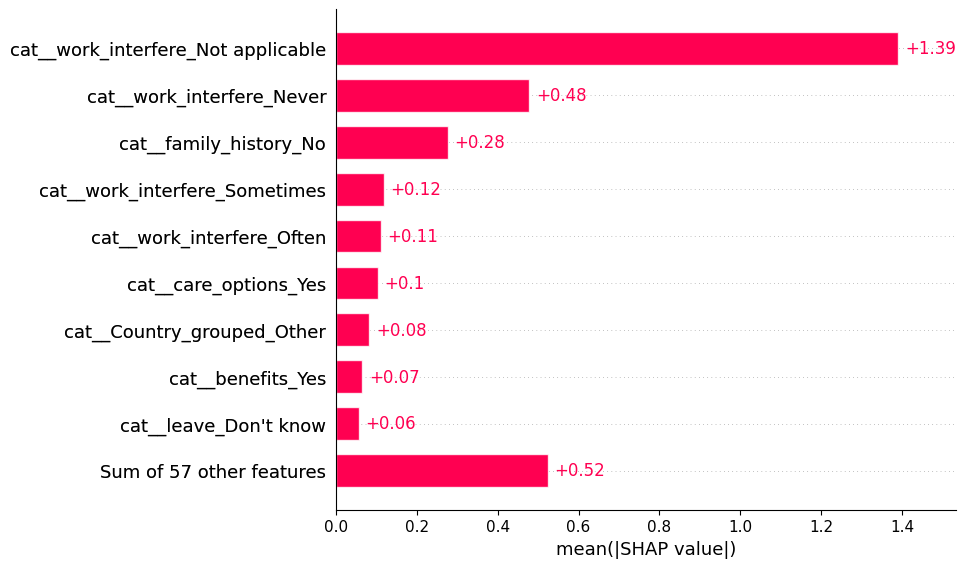

SHAP Summary - New Data


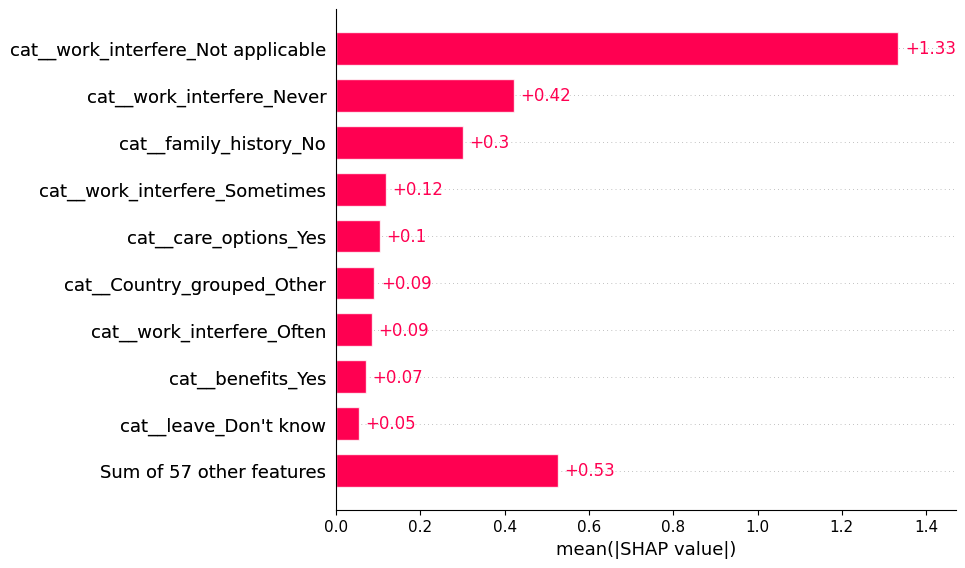

In [19]:
import shap

# Transform both datasets
X_train_np = preprocessor.transform(X_train)
X_new_np = preprocessor.transform(X_new)

# Convert to dense array if needed
X_train_np = X_train_np.toarray() if hasattr(X_train_np, "toarray") else X_train_np
X_new_np = X_new_np.toarray() if hasattr(X_new_np, "toarray") else X_new_np

# Get readable feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Create SHAP explainer with feature names
explainer = shap.Explainer(classifier, X_train_np, feature_names=feature_names)

# Sample 100 rows for SHAP explanation (for speed)
shap_train = explainer(X_train_np[:100])
shap_new = explainer(X_new_np[:100])

# Plot summary
print("SHAP Summary - Training Data")
shap.plots.bar(shap_train, max_display=10)

print("SHAP Summary - New Data")
shap.plots.bar(shap_new, max_display=10)

## SHAP Value Comparison: Training vs New Data

We analyzed the SHAP feature importance summaries of both the original training data and the simulated new data to evaluate whether observed data drift (especially in gender variables) translated into meaningful changes in the model’s decision logic.

### Top SHAP Features — Overview

#### Training Data SHAP Summary:
- Top contributors are `cat__work_interfere_Not applicable`, `cat__work_interfere_Never`,  `cat__family_history_No`, `cat__work_interfere_Sometimes`,  `cat__work_interfere_Often`, `cat__care_options_Yes`

#### New Data SHAP Summary:
- Almost identical top contributors with slightly adjusted SHAP magnitudes.  
- Feature ranking remains stable, with minor fluctuation in mean(|SHAP|) values.

### Key Observations:

- The features identified as **drifted by KS test** — namely `cat__Gender_Male` and `cat__Gender_Female` — **do not appear** in the **top 10 SHAP features** in either training or new data.
- This indicates that **although gender distributions shifted**, these variables have **minimal influence** on the model’s predictions and are **not central to its decision-making process**.
- The most influential feature across both datasets is clearly `cat__work_interfere_Not applicable`, maintaining **high and consistent contribution** in both cases (SHAP ≈ 1.33–1.39).

### Interpretation:

- **No evidence of functional model drift** was observed based on SHAP importance. The model continues to rely on the same dominant features to drive predictions.
- The **observed demographic drift** (in gender) is therefore likely **cosmetic** in nature — it alters the dataset profile but **does not affect how the model makes decisions**.
- This suggests that **model behavior is stable**, and retraining or recalibration is **not currently necessary** from a predictive logic perspective.

## Conclusion

- We confirm that the features impacted by input distribution drift are **not influential enough to cause concept drift**.
- The model remains **interpretable, stable, and trustworthy** under the new data conditions.
- As a precaution, we recommend setting up **monitoring alerts** for gender ratio in production data streams, but **no corrective action** is required at this time.

In [21]:
def compare_shap_topk_overlap(shap_values_train, shap_values_new, feature_names, k=10):
    """
    Compare the top-K SHAP features between training and new data
    and compute Jaccard similarity.
    """
    # Get mean absolute SHAP values for both sets
    shap_mean_train = np.abs(shap_values_train.values).mean(axis=0)
    shap_mean_new = np.abs(shap_values_new.values).mean(axis=0)

    # Rank feature indices
    topk_train_idx = np.argsort(shap_mean_train)[-k:][::-1]
    topk_new_idx = np.argsort(shap_mean_new)[-k:][::-1]

    # Convert to feature name sets
    topk_train_features = set(feature_names[i] for i in topk_train_idx)
    topk_new_features = set(feature_names[i] for i in topk_new_idx)

    # Calculate Jaccard similarity
    intersection = topk_train_features.intersection(topk_new_features)
    union = topk_train_features.union(topk_new_features)
    jaccard_sim = len(intersection) / len(union)

    print(f"Top-{k} SHAP Overlap:")
    print(f"Train top-{k}: {topk_train_features}")
    print(f"New top-{k}:   {topk_new_features}")
    print(f"Common features: {intersection}")
    print(f"Jaccard Similarity: {jaccard_sim:.2f}")

    return {
        "topk_train": topk_train_features,
        "topk_new": topk_new_features,
        "intersection": intersection,
        "jaccard_similarity": jaccard_sim
    }

# Example usage:
compare_shap_topk_overlap(shap_train, shap_new, feature_names, k=10)

Top-10 SHAP Overlap:
Train top-10: {'cat__coworkers_Yes', 'cat__care_options_Yes', 'cat__benefits_Yes', 'cat__work_interfere_Sometimes', 'cat__work_interfere_Not applicable', 'cat__work_interfere_Often', 'cat__work_interfere_Never', 'cat__Country_grouped_Other', 'cat__family_history_No', "cat__leave_Don't know"}
New top-10:   {'cat__care_options_Yes', 'cat__family_history_Yes', 'cat__benefits_Yes', 'cat__work_interfere_Sometimes', 'cat__work_interfere_Not applicable', 'cat__work_interfere_Often', 'cat__work_interfere_Never', 'cat__Country_grouped_Other', 'cat__family_history_No', "cat__leave_Don't know"}
Common features: {'cat__care_options_Yes', 'cat__benefits_Yes', 'cat__work_interfere_Not applicable', 'cat__work_interfere_Sometimes', 'cat__work_interfere_Often', 'cat__work_interfere_Never', 'cat__Country_grouped_Other', 'cat__family_history_No', "cat__leave_Don't know"}
Jaccard Similarity: 0.82


{'topk_train': {'cat__Country_grouped_Other',
  'cat__benefits_Yes',
  'cat__care_options_Yes',
  'cat__coworkers_Yes',
  'cat__family_history_No',
  "cat__leave_Don't know",
  'cat__work_interfere_Never',
  'cat__work_interfere_Not applicable',
  'cat__work_interfere_Often',
  'cat__work_interfere_Sometimes'},
 'topk_new': {'cat__Country_grouped_Other',
  'cat__benefits_Yes',
  'cat__care_options_Yes',
  'cat__family_history_No',
  'cat__family_history_Yes',
  "cat__leave_Don't know",
  'cat__work_interfere_Never',
  'cat__work_interfere_Not applicable',
  'cat__work_interfere_Often',
  'cat__work_interfere_Sometimes'},
 'intersection': {'cat__Country_grouped_Other',
  'cat__benefits_Yes',
  'cat__care_options_Yes',
  'cat__family_history_No',
  "cat__leave_Don't know",
  'cat__work_interfere_Never',
  'cat__work_interfere_Not applicable',
  'cat__work_interfere_Often',
  'cat__work_interfere_Sometimes'},
 'jaccard_similarity': 0.8181818181818182}

## SHAP Top-10 Overlap Analysis

To further quantify explanation-level stability, we compared the **Top-10 most influential SHAP features** from the training set and the new (simulated) data.

### Result Summary:
- **Jaccard Similarity Score**: **0.82**, indicating **very high agreement** between the two feature sets.
- **9 out of 10 features overlapped**, showing strong consistency in the model's decision logic despite minor input drift.
- The only difference was:
  - Training data included: `cat__coworkers_Yes`
  - New data included: `cat__family_history_Yes`

### Interpretation:
- A Jaccard score above 0.8 suggests that the model’s core reasoning structure **remains highly stable** under new data.
- This overlap confirms that the previously observed gender-related input drift **does not propagate into explanation drift**.
- The one feature difference (`cat__coworkers_Yes` replaced by `cat__family_history_Yes`) is minor and does not suggest a structural shift in decision-making.

### Conclusion:
The model demonstrates strong **explanation robustness**. Its behavior and dominant feature influences remain **largely unchanged**, validating its suitability for continued deployment under the new data distribution.

> **Note:**  
> The "new data" used for this drift analysis is **synthetically simulated** from the original dataset.  
> As a result, the feature distribution and SHAP explanation structure may appear **artificially similar**, which can partially mask real-world drift dynamics.
>
> This limitation reinforces the importance of:
> - Testing across **multiple model variants** (e.g., XGBoost with Random Search vs Optuna tuning)
> - Embedding these models into a **drift-aware pipeline** that continuously monitors for:
>   - Input distributional shifts  
>   - SHAP-based explanation changes  
>   - Performance degradation when true labels become available
>
> In production, real-world data is expected to introduce **unpredictable changes**, and proactively tracking model stability under such changes is essential for maintaining trust and reliability.

# AUC ROC Curve

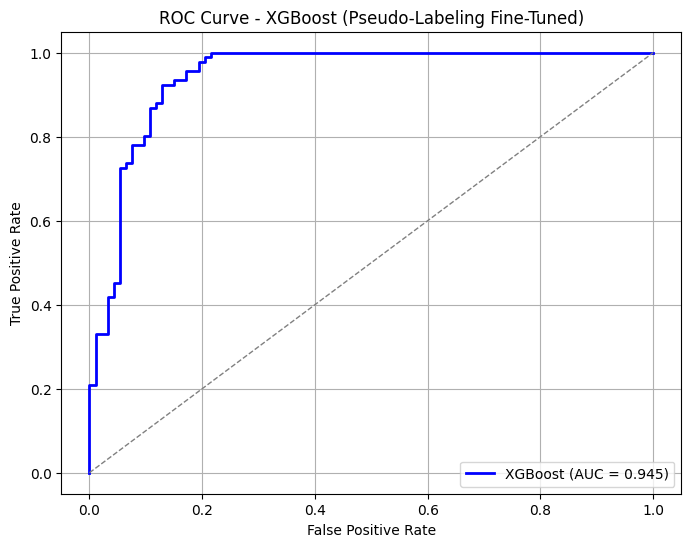

In [22]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import joblib

# Predict probabilities (make sure to use predict_proba)
y_proba_xgb = best_pipeline.predict_proba(X_test_xgb)[:, 1]  # Take the probability of the positive class (1)

# Compute False Positive Rate and True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test_xgb, y_proba_xgb)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Pseudo-Labeling Fine-Tuned)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

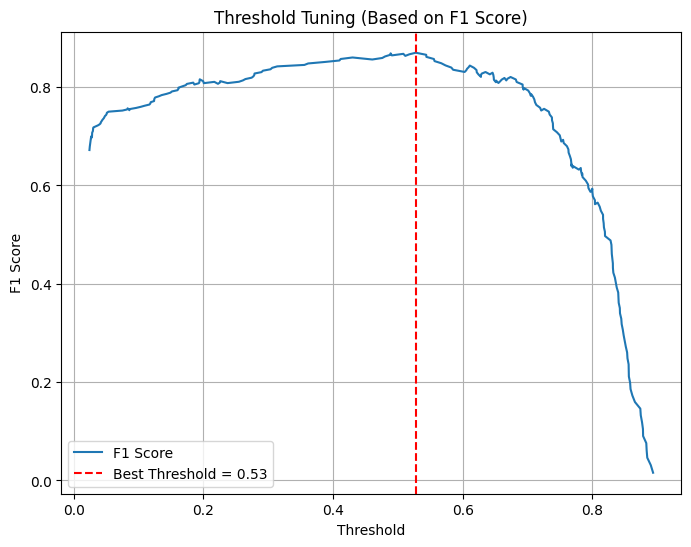

Best threshold: 0.528
Best F1 score: 0.870

===== Optuna Model Classification Report (F1-Optimized Threshold) =====
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       124
           1       0.82      0.92      0.87       127

    accuracy                           0.86       251
   macro avg       0.87      0.86      0.86       251
weighted avg       0.87      0.86      0.86       251



In [24]:
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Predict probabilities from Optuna-tuned model ===
y_proba_optuna = best_pipeline.predict_proba(X_test)[:, 1]

# === Step 2: Precision-Recall curve and F1 tuning ===
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_optuna)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# === Step 3: Plot F1 vs Threshold ===
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.2f}")
plt.title("Threshold Tuning (Based on F1 Score)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# === Step 4: Re-classify using best threshold ===
y_pred_optuna_tuned = (y_proba_optuna >= best_threshold).astype(int)

# === Step 5: Print new classification report ===
print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 score: {best_f1:.3f}\n")

print("===== Optuna Model Classification Report (F1-Optimized Threshold) =====")
print(classification_report(y_test, y_pred_optuna_tuned))

## ROC vs Threshold-Based Metrics Analysis

We compared two XGBoost models:
- One tuned XGBoost via **Random Search** (ultimately selected)
- One tuned XGBoost via **Optuna** (with slightly higher AUC)

### Performance Snapshot (Before Threshold Tuning)

| Metric               | Random Search Model | Optuna Model (Default Threshold) |
|----------------------|---------------------|----------------------------------|
| **AUC (ROC)**        | 0.937               | **0.945**                        |
| **Accuracy**         | **0.90**            | 0.86                             |
| **F1 Score**         | **0.90**            | 0.86                             |
| **Recall (class 1)** | 0.92                | **0.93**                         |
| **Precision (class 1)** | **0.88**         | 0.81                             |


### Why Threshold Tuning on the Optuna Model

Although the Optuna-tuned XGBoost model had a higher AUC — indicating **stronger probability ranking ability** — it suffered from:
- Lower **precision**, leading to more false positives
- Lower **F1-score** and **accuracy**, especially at the default threshold (0.5)

Since F1-score is a more balanced metric that weighs both false positives and false negatives, we attempted **threshold tuning** to find the probability cutoff that would maximize the Optuna model’s F1 performance.

### Threshold Tuning Results (Optuna Model)

- **Best Threshold Identified:** 0.528  
- **Best F1 Score Achieved:** 0.870  
- **New Accuracy:** 0.86  
- **Updated Performance (After Tuning):**

| Metric               | Random Search Model | Optuna Model (Tuned Threshold) |
|----------------------|---------------------|-------------------------------|
| **Accuracy**         | **0.90**            | 0.86                          |
| **F1 Score**         | **0.90**            | 0.87                          |
| **Precision (class 1)** | **0.88**         | 0.82                          |
| **Recall (class 1)** | 0.92                | **0.92**                      |

As shown, threshold tuning **did improve** the Optuna model's F1-score from 0.86 to 0.87. However, it still **did not surpass** the Random Search model's overall performance. The precision gap persisted, and accuracy remained lower.

### Final Decision: Random Search Model Selected

While Optuna achieved a higher AUC and improved slightly with threshold tuning, the **Random Search model remains superior in key business-facing metrics**:

- **Higher precision**, crucial in reducing false positives (e.g., wrongly predicting someone needs treatment)
- **Higher F1 and accuracy**, reflecting balanced and reliable classification under default and tuned thresholds


> This exercise demonstrates the importance of **evaluating beyond AUC**, especially when real-world applications rely on thresholded class predictions. Threshold tuning is a valuable diagnostic tool — but when even after tuning the model underperforms, the decision to stick with the better original model becomes clear and justified.